In [1]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from torchvision import transforms
from omegaconf import OmegaConf as oc

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen
import pathlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_dir = "datasets/wv_3d_square"

In [3]:
train_features = pickle.load(open(f"{data_dir}/train_features.pkl","rb"))
valid_features = pickle.load(open(f"{data_dir}/valid_features.pkl","rb"))
test_features = pickle.load(open(f"{data_dir}/test_features.pkl","rb"))
y_train = np.array([x[1] for x in torchvision.datasets.ImageFolder(f"{data_dir}/train")])
y_valid = np.array([x[1] for x in torchvision.datasets.ImageFolder(f"{data_dir}/valid")])
y_test = np.array([x[1] for x in torchvision.datasets.ImageFolder(f"{data_dir}/test")])

## search alignment

In [4]:
total_weights = np.array(list(itertools.product([0]+[2**i for i in range(10)],repeat=2)))
# total_weights = np.hstack([total_weights,np.zeros_like(total_weights)])
total_weights = np.hstack([total_weights,np.ones_like(total_weights)])

In [4]:
total_weights = np.array(list(itertools.product([0]+[2**i for i in range(10)],repeat=4)))

In [5]:
aligns = np.array([evals.distorted_1nn(train_features, y_train, test_features, y_test, weights) for weights in total_weights])

Text(0.5, 0, 'Align (%)')

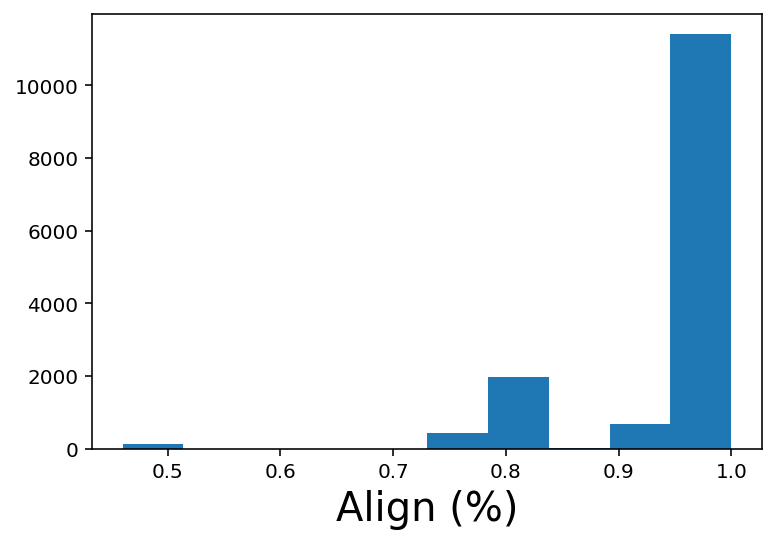

In [10]:
plt.hist(aligns)
plt.xlabel("Align (%)")
# plt.xticks([f"{x}%" for x in np.arange(5,11)*10])
# plt.x

In [17]:
align = 0.8925
total_weights[np.where(aligns==align)[0]]

array([[256,   0,   1,   1],
       [512,   0,   1,   1]])

In [7]:
np.unique(aligns)

array([0.4525, 0.67  , 0.6825, 0.685 , 0.6875, 0.69  , 0.6925, 0.695 ,
       0.8425, 0.8625, 0.8675, 0.875 , 0.8775, 0.88  , 0.885 , 0.8875,
       0.8925, 0.9125, 0.92  , 0.9275, 0.93  , 0.9325, 0.935 , 0.9375,
       0.94  , 0.9425, 0.945 , 0.9475, 0.95  , 0.9525, 0.955 , 0.9575,
       0.96  , 0.9625, 0.965 ])

In [14]:
evals.distorted_1nn(train_features, y_train, test_features, y_test, [1,1,1,1])

0.9475

## testing

In [18]:
weights = [
    [0,1,1,1],
    [1,0,1,1],
    [256,0,1,1],
    [1,1,1,1],
    [32,32,1,1],
]
aligns = [0.69,0.84,0.89,0.95,0.97]
for weight in weights:
    print(evals.distorted_1nn(train_features, y_train, test_features, y_test, weight))

0.685
0.8425
0.8925
0.9475
0.965


#### aligns & filtered

In [19]:
weights = [
    [0,1,1,1],
    [1,0,1,1],
    [256,0,1,1],
    [1,1,1,1],
    [32,32,1,1],
]
aligns = [0.69,0.84,0.89,0.95,0.97]
assert(len(weights)==len(aligns))
total = 40000
triplet_dir = data_dir + "_triplets"

In [20]:
for weight,align in zip(weights, aligns):
    train_triplets, valid_triplets, test_triplets, train_triplets_filtered, valid_triplets_filtered, test_triplets_filtered =\
        gen.get_alignment_filtered_triplets(train_features, valid_features, test_features, y_train, y_valid, y_test, weight, total)
    align_dir = os.path.join(triplet_dir,f"align={str(align)}")
    pathlib.Path(align_dir).mkdir(parents=True, exist_ok=True)
    pickle.dump(train_triplets, open(f"{align_dir}/train_triplets.pkl", "wb"))
    pickle.dump(valid_triplets, open(f"{align_dir}/valid_triplets.pkl", "wb"))
    pickle.dump(test_triplets, open(f"{align_dir}/test_triplets.pkl", "wb"))
    pickle.dump(train_triplets_filtered, open(f"{align_dir}/train_triplets_filtered.pkl","wb"))
    pickle.dump(valid_triplets_filtered, open(f"{align_dir}/valid_triplets_filtered.pkl","wb"))
    pickle.dump(test_triplets_filtered, open(f"{align_dir}/test_triplets_filtered.pkl","wb"))

### noisy

In [6]:
aligns = ["0.84","0.95"]
triplet_dir = data_dir + "_triplets"

In [7]:
for align in aligns:
    train_triplets = pickle.load(open(f"{triplet_dir}/align={align}/train_triplets.pkl","rb"))
    valid_triplets = pickle.load(open(f"{triplet_dir}/align={align}/valid_triplets.pkl","rb"))
    test_triplets = pickle.load(open(f"{triplet_dir}/align={align}/test_triplets.pkl","rb"))
    for p in np.arange(1,9,1)/10:
        dir = os.path.join(f"{triplet_dir}/align={align}_noisy",str(p))
        pathlib.Path(dir).mkdir(parents=True, exist_ok=True)

        train_noisy = gen.get_noisy_triplets(train_triplets, p)
        valid_noisy = gen.get_noisy_triplets(valid_triplets, p)
        test_noisy = gen.get_noisy_triplets(test_triplets, p)
        pickle.dump(train_noisy, open(f"{dir}/train_triplets.pkl","wb"))
        pickle.dump(valid_noisy, open(f"{dir}/valid_triplets.pkl","wb"))
        pickle.dump(test_noisy, open(f"{dir}/test_triplets.pkl","wb"))

In [8]:
for align in aligns:    
    for p in np.arange(1,9,1)/10:
        dir = os.path.join(f"{triplet_dir}/align={align}_noisy",str(p))
        train_triplets = pickle.load(open(f"{dir}/train_triplets.pkl","rb"))
        valid_triplets = pickle.load(open(f"{dir}/valid_triplets.pkl","rb"))
        test_triplets = pickle.load(open(f"{dir}/test_triplets.pkl","rb"))
        train_triplets_filtered = gen.filter_train_triplets(train_triplets, y_train)
        valid_triplets_filtered = gen.filter_mixed_triplets(valid_triplets, y_train, y_valid)
        test_triplets_filtered = gen.filter_mixed_triplets(test_triplets, y_train, y_test)
        pickle.dump(train_triplets_filtered, open(f"{dir}/train_triplets_filtered.pkl","wb"))
        pickle.dump(valid_triplets_filtered, open(f"{dir}/valid_triplets_filtered.pkl","wb"))
        pickle.dump(test_triplets_filtered, open(f"{dir}/test_triplets_filtered.pkl","wb"))

### nums

In [9]:
aligns = ["0.84","0.95"]
triplet_dir = data_dir + "_triplets"
def dropout(triplets,p):
    keepers = np.random.choice(np.arange(len(triplets)),int(len(triplets)*p),replace=False)
    return np.array(triplets)[keepers]

In [10]:
for align in aligns:
    train_triplets = pickle.load(open(f"{triplet_dir}/align={align}/train_triplets.pkl","rb"))
    valid_triplets = pickle.load(open(f"{triplet_dir}/align={align}/valid_triplets.pkl","rb"))
    test_triplets = pickle.load(open(f"{triplet_dir}/align={align}/test_triplets.pkl","rb"))
    for p in [1/128,1/64,1/32,1/16,1/8,1/4,1/2]:
        dir = os.path.join(f"{triplet_dir}/align={align}_num",str(p))
        pathlib.Path(dir).mkdir(parents=True, exist_ok=True)

        train_noisy = dropout(train_triplets, p)
        valid_noisy = dropout(valid_triplets, p)
        test_noisy = dropout(test_triplets, p)
        pickle.dump(train_noisy, open(f"{dir}/train_triplets.pkl","wb"))
        pickle.dump(valid_noisy, open(f"{dir}/valid_triplets.pkl","wb"))
        pickle.dump(test_noisy, open(f"{dir}/test_triplets.pkl","wb"))

In [11]:
for align in aligns:
    for p in [1/128,1/64,1/32,1/16,1/8,1/4,1/2]:
        dir = os.path.join(f"{triplet_dir}/align={align}_num",str(p))
        train_triplets = pickle.load(open(f"{dir}/train_triplets.pkl","rb"))
        valid_triplets = pickle.load(open(f"{dir}/valid_triplets.pkl","rb"))
        test_triplets = pickle.load(open(f"{dir}/test_triplets.pkl","rb"))
        train_triplets_filtered = gen.filter_train_triplets(train_triplets, y_train)
        valid_triplets_filtered = gen.filter_mixed_triplets(valid_triplets, y_train, y_valid)
        test_triplets_filtered = gen.filter_mixed_triplets(test_triplets, y_train, y_test)
        pickle.dump(train_triplets_filtered, open(f"{dir}/train_triplets_filtered.pkl","wb"))
        pickle.dump(valid_triplets_filtered, open(f"{dir}/valid_triplets_filtered.pkl","wb"))
        pickle.dump(test_triplets_filtered, open(f"{dir}/test_triplets_filtered.pkl","wb"))

## yaml generation

In [ ]:
weights = [
    [0,1,1,1],
    [1,0,1,1],
    [256,0,1,1],
    [1,1,1,1],
    [32,32,1,1],
]
aligns = [0.69,0.84,0.89,0.95,0.97]
data = "wv_syn_bm"
triplet_dir = data_dir + "_triplets"
yaml_dir = f"models/configs/{data}/triplets"

In [ ]:
dir = f"{yaml_dir}/unfiltered/aligns"
for weight,align in zip(weights, aligns):
    unfiltered_configs =  {"wandb_project": data + "_aligns",
                                "wandb_group": f"align={align}",
                                "train_triplets": f"../{triplet_dir}/align={align}/train_triplets.pkl",
                                "valid_triplets": f"../{triplet_dir}/align={align}/valid_triplets.pkl",
                                "test_triplets": f"../{triplet_dir}/align={align}/test_triplets.pkl",
                                "weights": weight,
                                "powers": [2,2],
                                "filtered": False}
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    oc.save(unfiltered_configs, f"{dir}/align={align}.yaml")

In [ ]:
dir = f"{yaml_dir}/filtered/aligns"
for weight,align in zip(weights, aligns):
    filtered_configs =  {"wandb_project": data + "_aligns",
                                "wandb_group": f"align={align}_filtered",
                                "train_triplets": f"../{triplet_dir}/align={align}/train_triplets_filtered.pkl",
                                "valid_triplets": f"../{triplet_dir}/align={align}/valid_triplets_filtered.pkl",
                                "test_triplets": f"../{triplet_dir}/align={align}/test_triplets_filtered.pkl",
                                "weights": weight,
                                "powers": [2,2],
                                "filtered": True}
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    oc.save(filtered_configs, f"{dir}/align={align}.yaml")

### noise

In [15]:
weights = [
    [1,0,1,1],
    [1,1,1,1],
]
aligns = ["0.84","0.95"]

data = "wv_squarelin"
triplet_dir = data + "_triplets"
yaml_dir = f"models/configs/{data}/triplets"

In [16]:
for weight, align in zip(weights, aligns):
    dir = f"{yaml_dir}/unfiltered/noisy_{align}" 
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    for p in np.arange(1,9,1)/10:
        unfiltered_configs =  {"wandb_project": data + "_noisy",
                                    "wandb_group": f"align={align}_p={p}",
                                    "train_triplets": f"../datasets/{triplet_dir}/align={align}_noisy/{p}/train_triplets.pkl",
                                    "valid_triplets": f"../datasets/{triplet_dir}/align={align}_noisy/{p}/valid_triplets.pkl",
                                    "test_triplets": f"../datasets/{triplet_dir}/align={align}_noisy/{p}/test_triplets.pkl",
                                    "weights": weight,
                                    "powers": [2,2],
                                    "filtered": False}
        oc.save(unfiltered_configs, f"{dir}/p={p}.yaml")

In [17]:
for weight, align in zip(weights, aligns):
    dir = f"{yaml_dir}/filtered/noisy_{align}" 
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    for p in np.arange(1,9,1)/10:
        filtered_configs =  {"wandb_project": data + "_noisy",
                                    "wandb_group": f"align={align}_p={p}_filtered",
                                    "train_triplets": f"../datasets/{triplet_dir}/align={align}_noisy/{p}/train_triplets_filtered.pkl",
                                    "valid_triplets": f"../datasets/{triplet_dir}/align={align}_noisy/{p}/valid_triplets_filtered.pkl",
                                    "test_triplets": f"../datasets/{triplet_dir}/align={align}_noisy/{p}/test_triplets_filtered.pkl",
                                    "weights": weight,
                                    "powers": [2,2],
                                    "filtered": True}
        oc.save(filtered_configs, f"{dir}/p={p}.yaml")

### num

In [18]:
weights = [
    [1,0,1,1],
    [1,1,1,1],
]
aligns = ["0.84","0.95"]

data = "wv_squarelin"
triplet_dir = data + "_triplets"
yaml_dir = f"models/configs/{data}/triplets"

In [19]:
for weight, align in zip(weights, aligns):
    dir = f"{yaml_dir}/unfiltered/num_{align}" 
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    for p in [1/2, 1/128, 1/64, 1/32,1/16,1/8,1/4]:
        unfiltered_configs =  {"wandb_project": data + "_num",
                                    "wandb_group": f"align={align}_p={p}",
                                    "train_triplets": f"../datasets/{triplet_dir}/align={align}_num/{p}/train_triplets.pkl",
                                    "valid_triplets": f"../datasets/{triplet_dir}/align={align}_num/{p}/valid_triplets.pkl",
                                    "test_triplets": f"../datasets/{triplet_dir}/align={align}_num/{p}/test_triplets.pkl",
                                    "weights": weight,
                                    "powers": [2,2],
                                    "filtered": False,
                                    "model": "MTL_slow"}
        oc.save(unfiltered_configs, f"{dir}/p={p}.yaml")


In [20]:
for weight, align in zip(weights, aligns):
    dir = f"{yaml_dir}/filtered/num_{align}" 
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    for p in [1/2, 1/128, 1/64, 1/32,1/16,1/8,1/4]:
        filtered_configs =  {"wandb_project": data + "_num",
                                    "wandb_group": f"align={align}_p={p}_filtered",
                                    "train_triplets": f"../datasets/{triplet_dir}/align={align}_num/{p}/train_triplets_filtered.pkl",
                                    "valid_triplets": f"../datasets/{triplet_dir}/align={align}_num/{p}/valid_triplets_filtered.pkl",
                                    "test_triplets": f"../datasets/{triplet_dir}/align={align}_num/{p}/test_triplets_filtered.pkl",
                                    "weights": weight,
                                    "powers": [2,2],
                                    "filtered": True,
                                    "model": "MTL_slow"}
        oc.save(filtered_configs, f"{dir}/p={p}.yaml")